#  Generate data

In [2]:
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi,jnp
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

m = bi(platform='cpu')

jax.local_device_count 32


# Data

In [3]:
data, true_labels = make_blobs(
    n_samples=500, centers=8, cluster_std=0.8,
    center_box=(-10,10), random_state=101
)
N, D = data.shape
T=10


# DPMM

sample: 100%|██████████| 1000/1000 [00:35<00:00, 27.94it/s, 63 steps of size 4.79e-02. acc. prob=0.94]


⚠️This function is still in development. Use it with caution. ⚠️
⚠️This function is still in development. Use it with caution. ⚠️
Model found 9 clusters.


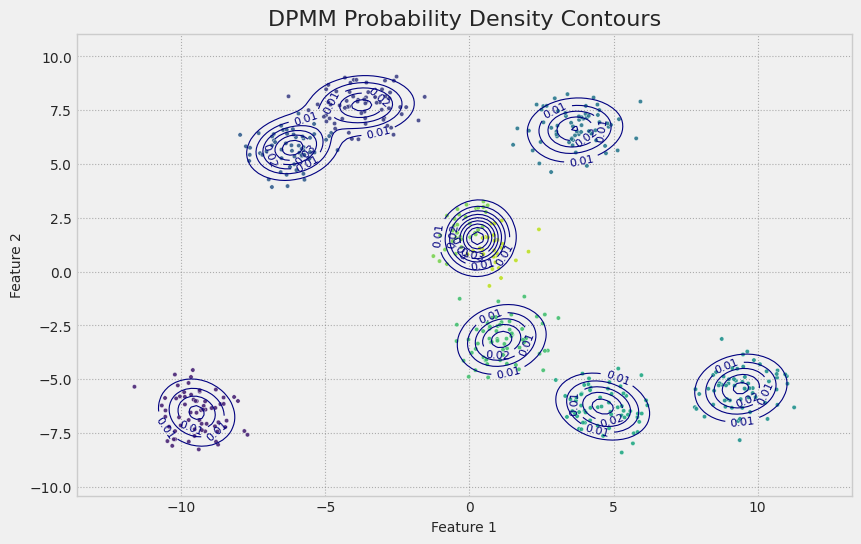

In [ ]:
m.data_on_model = dict(data=data,T=10)
m.fit(m.models.dpmm)
m.plot(data,m.sampler)

# GMM

sample: 100%|██████████| 1000/1000 [00:07<00:00, 130.27it/s, 15 steps of size 4.07e-01. acc. prob=0.90]


⚠️This function is still in development. Use it with caution. ⚠️
⚠️This function is still in development. Use it with caution. ⚠️


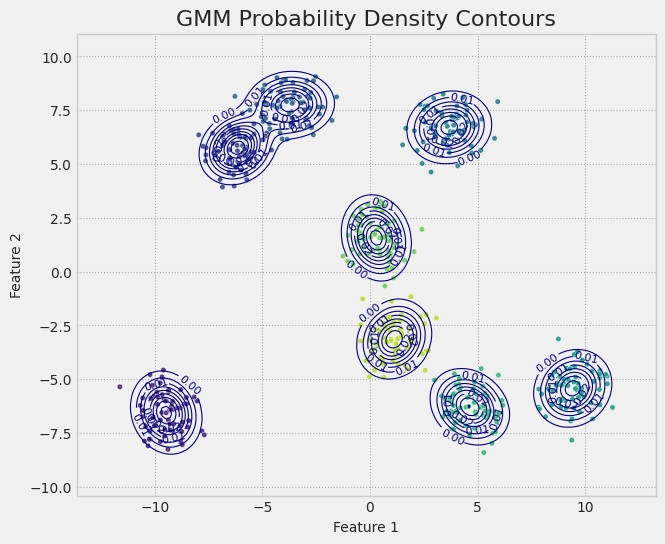

In [4]:

m.data_on_model = {
    "data": data,
    "K": 8 # You must pass the number of clusters you want to find
}
m.ml.KMEANS(m.data_on_model['data'], n_clusters=m.data_on_model['K'])

m.fit(m.gmm)
m.plot(X=data,sampler=m.sampler)

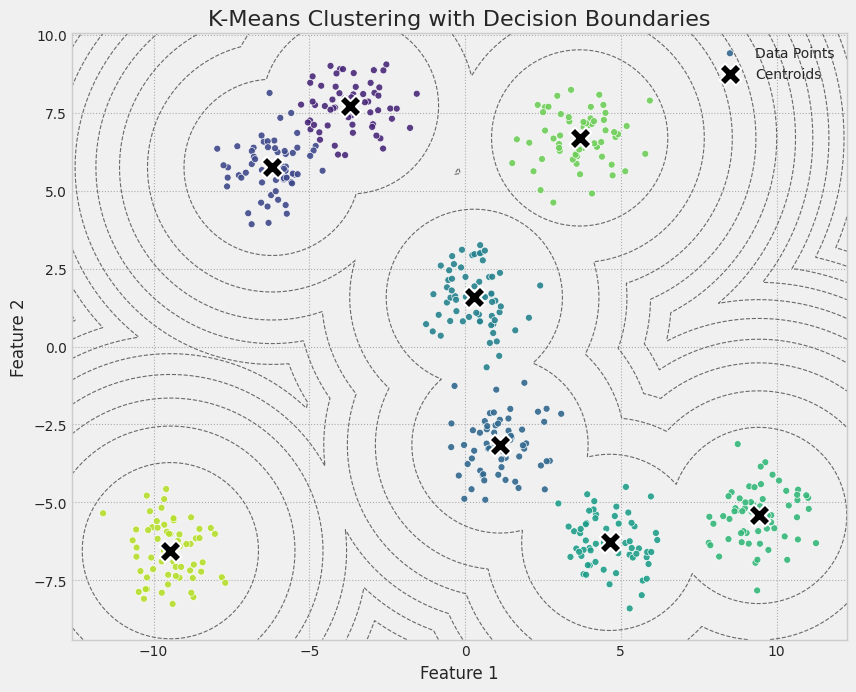

In [6]:
m.ml.KMEANS(
        data,
        n_clusters=8,
        n_iterations=150,
        random_state=42
    ).predict(data)
m.ml.plot(data)

# GMM step by step

In [56]:
def gmmTest(data, K, initial_means): 
    """
    Gaussian Mixture Model with a fixed number of clusters K.
    Parameters:
    - data: Input data points (shape: [N, D] where N is the number of samples and D is the number of features).
    - K: The exact number of clusters.
    - initial_means: Initial means for the clusters (shape: [K, D]). If not provided, it is initialized using K-means.
    Returns:
    - A model that defines the GMM with K clusters.
    This model assumes that the data is generated from a mixture of K Gaussian distributions.
    The model estimates the means, covariances, and mixture weights for each cluster.
    The number of clusters K is fixed and must be specified in advance.
    """
    D = data.shape[1]  # Number of features
    alpha_prior = 0.5 * jnp.ones(K)
    w =  m.dist.dirichlet(concentration=alpha_prior, name='weights') 

    with  m.dist.plate("components", K): # Use fixed K
        mu = m.dist.multivariate_normal(loc=initial_means, covariance_matrix=0.1*jnp.eye(D), name='mu')        
        sigma =  m.dist.half_cauchy(1, shape=(D,), event=1, name='sigma')
        Lcorr =  m.dist.lkj_cholesky(dimension=D, concentration=1.0, name='Lcorr')

        scale_tril = sigma[..., None] * Lcorr
        print('mu', mu.shape)
        print('sigma', sigma.shape)
        print('Lcorr', Lcorr.shape)
        print('scale_tril', scale_tril.shape)

    ## 3) marginal mixture over obs (this part remains almost identical)
    #with numpyro.plate('data', len(data)):
    #    assignment = numpyro.sample('assignment', dist.Categorical(w),infer={"enumerate": "parallel"}) 
    #    numpyro.sample('obs', dist.MultivariateNormal(mu[assignment,:][1], sigma[assignment][1]*jnp.eye(D)), obs=data)
    #    
    m.dist.mixture_same_family(
        mixing_distribution= m.dist.categorical(probs=w, create_obj=True),
        component_distribution= m.dist.multivariate_normal(loc=mu, scale_tril=scale_tril, create_obj=True),
        name="obs",
        obs=data
    )
m.fit(gmmTest)

mu (8, 2)
sigma (8, 2)
Lcorr (8, 2, 2)
scale_tril (8, 2, 2)
mu (8, 2)
sigma (8, 2)
Lcorr (8, 2, 2)
scale_tril (8, 2, 2)


  0%|          | 0/1000 [00:00<?, ?it/s]

mu (8, 2)
sigma (8, 2)
Lcorr (8, 2, 2)
scale_tril (8, 2, 2)


sample: 100%|██████████| 1000/1000 [00:09<00:00, 109.00it/s, 15 steps of size 4.07e-01. acc. prob=0.90]


In [64]:
m.posteriors.keys()

dict_keys(['Lcorr', 'mu', 'sigma', 'weights'])

In [63]:
0.1*jnp.eye(D)

Array([[0.1, 0. ],
       [0. , 0.1]], dtype=float64)

In [62]:
K = 8
D = data.shape[1]


# $\pi \sim \text{Dirichlet}([0.5, \dots, 0.5])$
alpha_prior = 0.5 * jnp.ones(K)
w = m.dist.dirichlet(concentration=alpha_prior, name='weights', sample = True) 
print('w shape:', w.shape)

#  Initial means for the clusters (shape: [K, D])
m.ml.KMEANS(data,n_clusters=K)
initial_means = m.ml.results['centroids']
print('Initial means shape: ',initial_means.shape)



#$\mu  \sim \text{MultivariateNormal}(\mu_k, \Sigma_k)$
mu = m.dist.multivariate_normal(loc=initial_means, covariance_matrix=0.1*jnp.eye(D), name='mu', sample=True) 
print('Mu shape: ', mu.shape)

#$\Sigma \sim \text{HalfCauchy}(1)$
sigma =  m.dist.half_cauchy(1, shape=(K,D), event=1, name='sigma', sample=True)
print('sigma shape: ',sigma.shape)

# $L \sim \text{LKJCholesky}(D, 1.0)$
Lcorr =  m.dist.lkj_cholesky(dimension=D, shape = (K,), concentration=1.0, name='Lcorr', sample=True)
print('Lcorr shape: ',Lcorr.shape)

# $\Sigma_k = \text{diag}(\sigma_k) L_k L_k^T \text{diag}(\sigma_k)$
scale_tril = sigma[..., None] * Lcorr
print('scale_tril shape: ',scale_tril.shape)

# Mixture over observations
# $ X_i \sim \sum_{k=1}^{K} \pi_k \mathcal{N}(\mu_k, \Sigma_k) $
res = m.dist.mixture_same_family(
    mixing_distribution= m.dist.categorical(probs=w, create_obj=True),
    component_distribution= m.dist.multivariate_normal(loc=mu, scale_tril=scale_tril, create_obj=True),
    name="obs",
    sample  = True,
    shape=(data.shape[0],)
)
res.shape

w shape: (8,)
Initial means shape:  (8, 2)
Mu shape:  (8, 2)
sigma shape:  (8, 2)
Lcorr shape:  (8, 2, 2)
scale_tril shape:  (8, 2, 2)


(500, 2)